In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import accuracy_score,f1_score
from transformers import AutoModel, AutoTokenizer, LlamaForCausalLM, LlamaTokenizerFast
from datasets import load_dataset
from peft import PeftModel
from tqdm import tqdm
import pandas as pd
import datasets
import torch

[2023-07-27 17:08:04,438] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA SETUP: CUDA runtime path found: /xfs/home/tensor_zy/anaconda3/envs/isaacgym/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


### Load Models

In [3]:
# Load Models
base_model = "meta-llama/Llama-2-7b-chat-hf"
# peft_model = "oliverwang15/FinGPT_ChatGLM2_Sentiment_Instruction_LoRA_FT"
# peft_model = "../../finetuned_model"
tokenizer = LlamaTokenizerFast.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
model = LlamaForCausalLM.from_pretrained(base_model, trust_remote_code=True, device_map = "auto")
# model = PeftModel.from_pretrained(model, peft_model)
model = model.eval()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Load Datasets

In [4]:
dic = {
    0:"negative",
    1:'positive',
    2:'neutral',
}

def format_example(example: dict) -> dict:
    context = f"Instruction: {example['instruction']}\n"
    if example.get("input"):
        context += f"Input: {example['input']}\n"
    context += "Answer: "
    target = example["output"]
    return {"context": context, "target": target}

def change_target(x):
    if 'positive' in x or 'Positive' in x:
        return 'positive'
    elif 'negative' in x or 'Negative' in x:
        return 'negative'
    else:
        return 'neutral'

def test_tfns(model, tokenizer, batch_size = 8, prompt_fun = None ):
    dataset = load_dataset('zeroshot/twitter-financial-news-sentiment')
    dataset = dataset['validation']
    dataset = dataset.to_pandas()
    dataset['label'] = dataset['label'].apply(lambda x:dic[x])
    
    if prompt_fun is None:
        dataset["instruction"] = 'What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.'
    else:
        dataset["instruction"] = dataset.apply(prompt_fun, axis = 1)

    dataset.columns = ['input', 'output', 'instruction']
    dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")

    # print example
    print(f"\n\nPrompt example:\n{dataset['context'][0]}\n\n")

    context = dataset['context'].tolist()
    
    total_steps = dataset.shape[0]//batch_size + 1
    print(f"Total len: {len(context)}. Batchsize: {batch_size}. Total steps: {total_steps}")


    out_text_list = []
    for i in tqdm(range(total_steps)):
        tmp_context = context[i* batch_size:(i+1)* batch_size]
        tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
        tokens.pop('token_type_ids')
        for k in tokens.keys():
            tokens[k] = tokens[k].cuda()
        res = model.generate(**tokens, max_length=512)
        res_sentences = [tokenizer.decode(i) for i in res]
        out_text = [o.split("Answer: ")[1] for o in res_sentences]
        out_text_list += out_text
        torch.cuda.empty_cache()

    dataset["out_text"] = out_text_list
    dataset["new_target"] = dataset["target"].apply(change_target)
    dataset["new_out"] = dataset["out_text"].apply(change_target)

    acc = accuracy_score(dataset["new_target"], dataset["new_out"])
    f1_macro = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
    f1_micro = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
    f1_weighted = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")

    print(f"Acc: {acc}. F1 macro: {f1_macro}. F1 micro: {f1_micro}. F1 weighted (BloombergGPT): {f1_weighted}. ")

    return dataset

Acc: 0.6641541038525963. F1 macro: 0.6596022406545043. F1 micro: 0.6641541038525963. F1 weighted (BloombergGPT): 0.6696344293081012. 

In [5]:
dataset = test_tfns(model, tokenizer)

Found cached dataset csv (/xfs/home/tensor_zy/.cache/huggingface/datasets/zeroshot___csv/zeroshot--twitter-financial-news-sentiment-467590c9f24f65ad/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/2 [00:00<?, ?it/s]



Prompt example:
Instruction: What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.
Input: $ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5
Answer: 


Total len: 2388. Batchsize: 8. Total steps: 299


100%|██████████| 299/299 [10:16<00:00,  2.06s/it]

Acc: 0.3860971524288107. F1 macro: 0.4012554633352747. F1 micro: 0.3860971524288107. F1 weighted (BloombergGPT): 0.29592313669795683. 


<AxesSubplot:>

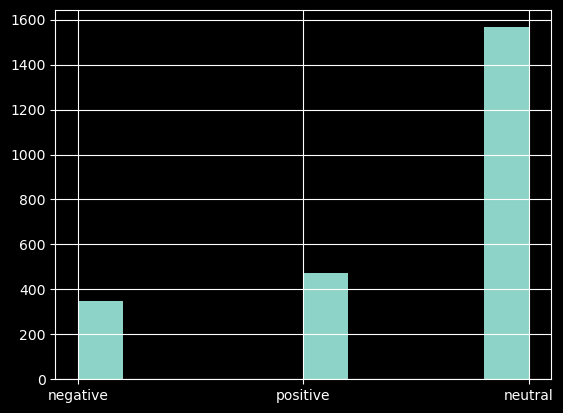

In [6]:
dataset["new_target"].hist()

<AxesSubplot:>

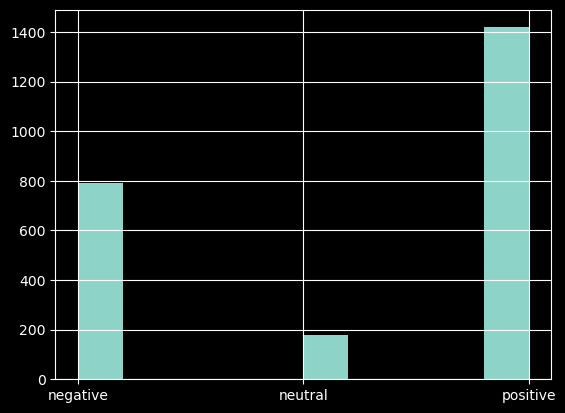

In [7]:
dataset["new_out"].hist()